In [1]:
# ======================================
# 0. 기본 라이브러리
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from bs4 import BeautifulSoup
import requests
import openpyxl
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
from selenium.webdriver.common.by  import By
from selenium.webdriver.common.keys import Keys

from pathlib import Path
import shutil
from datetime import datetime

import matplotlib.font_manager as fm
from matplotlib import rcParams


# ======================================
# 1. 스타일 먼저 (중요: 폰트보다 먼저)
# ======================================
plt.style.use('_mpl-gallery-nogrid')   # matplotlib 스타일
sns.set_theme(style="white")           # seaborn 기본 테마

# ======================================
# 2. 폰트 설정 (나눔고딕)
# ======================================
FONT_PATH = r"E:\seoul_pv_load_analysis\fonts\NanumGothic.ttf"

# matplotlib에 폰트 등록
fm.fontManager.addfont(FONT_PATH)

# 전역 폰트 지정
rcParams["font.family"] = "NanumGothic"

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False

# (선택) 기본 폰트 사이즈 살짝 키우기
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# ======================================
# 3. 개별 객체용 폰트 (pie, title 등)
# ======================================
font_prop = fm.FontProperties(fname=FONT_PATH)

# ======================================
# 4. seaborn스타일 설정
# ======================================
sns.set_style("ticks") # 스타일 테마 설정
sns.set_context("notebook") # 문맥에 따라 스타일 크기 조정
sns.set_palette("pastel")

### DAY 4: 전력 부하 vs 태양광 패턴 비교

**목적**
- 전력 수요와 태양광 발전 간 시간대 불일치 구조 확인

**주요 작업**
- 전력 부하 곡선과 PV 패턴 곡선 시각화
- PV로 직접 대응 불가 시간대 확인

**산출물**
- 덕 커브 구조 비교 그래프

In [ ]:
'''
DAY 4  목표
- DAY 4에서는 전력 수요와 태양광 발전 간의 시간대 불일치가
- 실제 운영 부담(Net Load)으로 어떻게 나타나는지를 정량적으로 확인하고,
- ESS 등 운영 자원이 개입해야 할 시간대와 규모를 데이터로 제시한다.
'''

In [2]:
# 경로 설정
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)


if not LOAD_FILE.exists():
    raise FileNotFoundError(f"데이터 파일 없음 : {LOAD_FILE}")

# 데이터로드
df = pd.read_csv(LOAD_FILE, encoding = "utf-8-sig")

# datetime 생성
df["date"] = pd.to_datetime(df["USE_YM"], format = "%Y%m%d", errors = "coerce")
df["hour"] = (df["USE_HM"] // 100 - 1).astype("Int64")
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit = "h")

# value 생성
df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"].astype(str).str.replace(",", ""), errors = "coerce")
df_base = df[["datetime", "hour", "value"]].copy()

# DAY 2 산출물: 24h 평균 부하
load_profile_24h = (df_base.dropna(subset = ["value"]).groupby("hour", as_index = False)["value"].agg(load_mean = "mean").sort_values("hour"))
load_peak = load_profile_24h["load_mean"].max()

# DAY 3 산출물: PV 스케일
def make_pv_profile(hours = range(24), peak = 13, sigma = 2.3, sunrise = 7, sunset = 19):
    h = np.array(list(hours))
    pv = np.exp(-0.5 * ((h - peak) / sigma) ** 2)
    pv[(h < sunrise) | (h > sunset)] = 0
    return pv / pv.max()

pv_profile_24h = pd.DataFrame({"hour": range(24), "pv_norm": make_pv_profile()})
pv_ratio = 0.2 # DAY 3에서 쓴 대표 시나리오
pv_scaled_24h = pv_profile_24h.copy()
pv_scaled_24h["pv_kW"] = pv_scaled_24h["pv_norm"] * load_peak * pv_ratio

# DAY 4 준비완료!
print("===DAY 4 변수 준비 완료!===")
print("df_base:", df_base.shape)
print("load_profile_24h:", load_profile_24h.shape)
print("pv_profile_24h:", pv_profile_24h.shape)

===DAY 4 변수 준비 완료!===
df_base: (9754804, 3)
load_profile_24h: (24, 2)
pv_profile_24h: (24, 2)


In [3]:
# 1. Net Load 계산 (핵심)
# 정의: Net Load = Load - PV -> 태양광을 고려한 뒤, 계통이 실제로 감당해야 하는 부하

# 안전하게 다시 병합
net_df = (load_profile_24h.merge(pv_scaled_24h, on = "hour", how = "left").sort_values("hour"))
net_df["net_load"]  = net_df["load_mean"] - net_df["pv_kW"]
display(net_df)

,hour,load_mean,pv_norm,pv_kW,net_load
0,0,4828.966546,0.000000,0.000000,4828.966546
1,1,4436.061656,0.000000,0.000000,4436.061656
2,2,4301.931715,0.000000,0.000000,4301.931715
3,3,4069.172541,0.000000,0.000000,4069.172541
4,4,4467.956892,0.000000,0.000000,4467.956892
5,5,4570.492076,0.000000,0.000000,4570.492076
6,6,5000.093613,0.000000,0.000000,5000.093613
7,7,5677.409920,0.033285,50.908733,5626.501187
8,8,6575.992184,0.094142,143.988297,6432.003887
9,9,7246.801206,0.220405,337.104729,6909.696478


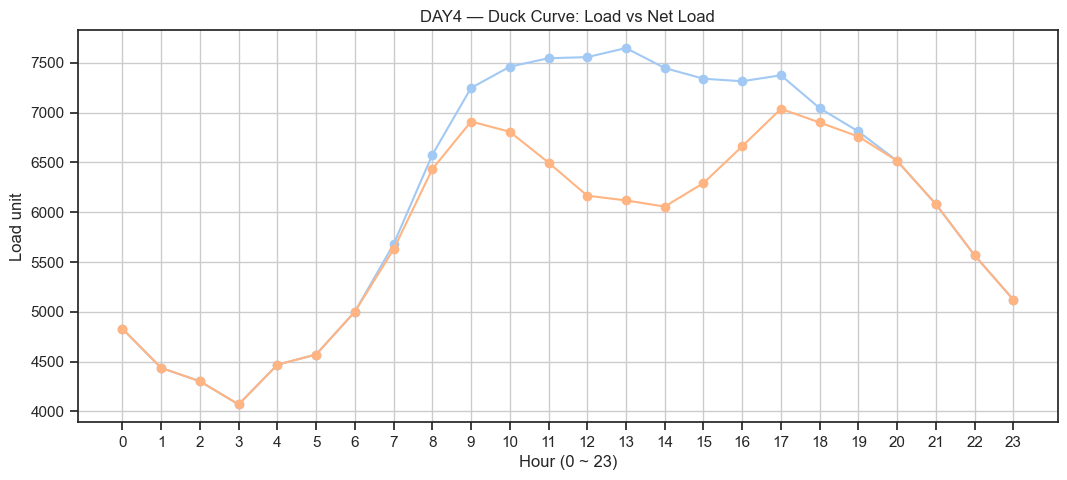

In [4]:
# 2. 덕커브 시각화
plt.figure(figsize = (10, 4))
plt.plot(net_df["hour"], net_df["load_mean"], marker = "o", label = "Load (Before PV)")
plt.plot(net_df["hour"], net_df["net_load"], marker = "o", label = "Net Load (After PV)")
plt.title("DAY4 — Duck Curve: Load vs Net Load")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Load unit")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.legend
plt.show()

In [5]:
# 3. 운영 관점 지표 1 - 잉여 / 부족 시간대
# ESS가 언제 필요하냐?
net_df["status"] = np.where(net_df["net_load"] > 0, "부족", "잉여 / 완화")
summary_time = (net_df.groupby("status")["hour"].count().rename("hours"))
display(summary_time)

status
부족    24
Name: hours, dtype: Int64

In [6]:
# 4. 운영 관점 지표 2 - 운영 부담 집중도
# 부담이 언제 가장 집중되냐?

# 저녁 피크 구간 정의 (운영 관점, 필요 시 조정)
peak_window = net_df[net_df["hour"].between(17, 20)]

total_net_load = net_df["net_load"].clip(lower = 0).sum()
peak_net_load = peak_window["net_load"].clip(lower = 0).sum()

peak_ratio = (peak_net_load / total_net_load) * 100

print(f"저녁 피크(17 ~ 20시) Net Load 비중: {peak_ratio:.1f}%")

저녁 피크(17 ~ 20시) Net Load 비중: 19.5%


In [7]:
# 5. ESS 필요성 "데이터로" 보여주기

# 잉여(완화)와 부족 규모 비교
surplus_energy = (-net_df["net_load"].clip(upper = 0)).sum() # 잉여 총량
deficit_energy = (net_df["net_load"].clip(lower = 0)).sum() # 부족 총량

print(f"낮 시간대 잉여(완화) 총량: {surplus_energy:.1f}")
print(f"저녁 중심 부족 총량: {deficit_energy:.1f}")

낮 시간대 잉여(완화) 총량: 0.0
저녁 중심 부족 총량: 139217.0


In [8]:
# 6. ESS 논리를 더 선명하게 만드는 방법
pv_ratios = [0.2, 0.3, 0.4]

results = []

for pv_ratio in pv_ratios:
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_peak * pv_ratio

    tmp = load_profile_24h.merge(pv_tmp, on = "hour")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    surplus = (-tmp["net_load"].clip(upper = 0)).sum() # 잉여 총량
    deficit = (tmp["net_load"].clip(lower = 0)).sum() # 부족 총량

    results.append({
        "PV_ratio_%": int(pv_ratio * 100),
        "Surplus_energy": round(surplus, 1),
        "Deficit_energy": round(deficit, 1)
    })

    scenario_df = pd.DataFrame(results)
    display(scenario_df)

,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0


,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0
1,30,0.0,134827.4


,PV_ratio_%,Surplus_energy,Deficit_energy
0,20,0.0,139217.0
1,30,0.0,134827.4
2,40,0.0,130437.9


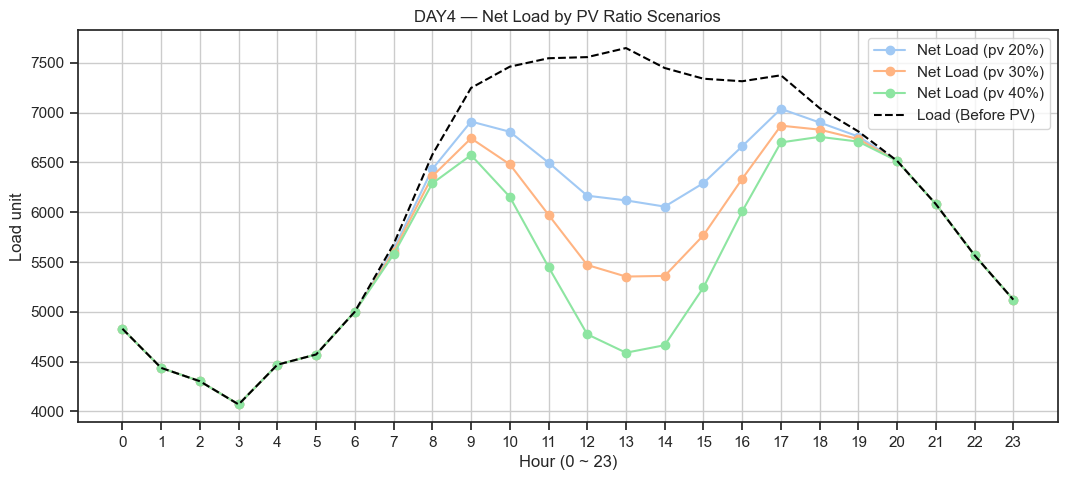

In [10]:
# 7. 덕 커브 비교 시각화
plt.figure(figsize = (10, 4))

for pv_ratio in pv_ratios:
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_peak * pv_ratio
    tmp = load_profile_24h.merge(pv_tmp, on = "hour")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    plt.plot(tmp["hour"], tmp["net_load"], marker = "o", label = f"Net Load (pv {int(pv_ratio * 100)}%)")

plt.plot(load_profile_24h["hour"], load_profile_24h["load_mean"], color = "black", linestyle = "--", label = "Load (Before PV)")
plt.title("DAY4 — Net Load by PV Ratio Scenarios")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Load unit")
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# 8. DATA 4 Final Narrative Generator
# - scenario_df 결과를 기반으로 해석 문장을 자동 생성

def _fmt(x):
    # None / NaN 방어
    try:
        return f"{float(x):,.1f}"
    except Exception:
        return str(x)
    
def generate_day4_narrative(scenario_df, pv_base = 20, pv_high = 40):
    # scenario_df columns expected:
    # - PV_ratio_% (int)
    # - Surplus_energy (float)
    # - Deficit_energy (float)

    # 행 찾기
    base_row = scenario_df.loc[scenario_df["PV_ratio_%"] == pv_base]
    high_row = scenario_df.loc[scenario_df["PV_ratio_%"] == pv_high]

    if base_row.empty or high_row.empty:
        raise ValueError(f"scenario_df에 {pv_base}% 또는 {pv_high}% 시나리오가 없습니다.")
    
    base_surplus = float(base_row["Surplus_energy"].iloc[0])
    base_deficit = float(base_row["Deficit_energy"].iloc[0])

    high_surplus = float(high_row["Surplus_energy"].iloc[0])
    high_deficit = float(high_row["Deficit_energy"].iloc[0])

    # 잉여 발생이 시작되는 최소 비율 찾기
    positive_surplus = scenario_df[scenario_df["Surplus_energy"] > 0]
    if positive_surplus.empty:
        start_ratio = None
    else:
        start_ratio = int(positive_surplus.sort_values("PV_ratio_%").iloc[0]["PV_ratio_%"])

    lines = []

    # 1) 20% 기준 결론
    if base_surplus <= 0:
        lines.append(
            f"PV 비율 {pv_base}% 시나리오에서는 순부하가 음(-)의 영역으로 전환되지 않아 잉여전력은 발생하지 않았으며, "
            f"태양광은 부하를 완화하되 저장이 필요한 수준의 잉여를 만들지는 못했다.")
    else:
        lines.append(
            f"PV 비율 {pv_base}% 시나리오에서도 낮 시간대 잉여 전력(총 {_fmt(base_surplus)})이 관측되어, "
            f"시간대 조정 자원의 필요성이 확인되었다.")
        
    # 2) 잉여 발생 시작 지점 언급
    if start_ratio is None:
        lines.append(
            "검토한 시나리오 범위 내에서는 낮 시간대 잉여 전력이 충분히 발생하지 않아, "
            "설비 확대만으로 운영 부담을 해소하기 어려운 구조임을 시사한다.")
    else:
        lines.append(
            f"PV 비율이 {start_ratio}% 이상으로 확대될 경우 낮 시간대 잉여 전력이 발생하기 시작하며, "
            "이는 저녁 피크 부족과 시간적으로 분리되어 나타난다.")
        
    # 3) 고비율(예: 40%) 수치 기반 보강
    lines.append(
        f"예를 들어 PV 비율 {pv_high}% 시나리오에서는 낮 잉여 총량이 {_fmt(high_surplus)}, "
        f"부족 총량이 {_fmt(high_deficit)}로 나타나, 에너지의 '총량'이 아니라 '시간 이동'이 핵심 과제로 드러났다.")
    
    # 4) 운영 / ESS 연결
    lines.append(
        "따라서 설비 확장만으로는 한계가 있으며, 낮 시간대 잉여를 저녁 피크로 이동시키는 ESS와 같은 "
        "시간대 조정 기반 운영 자원의 병행이 필요함을 시사한다.")
    
    return "\n".join([f"- {s}" for s in lines])

# 실행
final_text = generate_day4_narrative(scenario_df, pv_base = 20, pv_high = 40)
print("===DAY 4 최종 해석 문장===")
print(final_text)

===DAY 4 최종 해석 문장===
- PV 비율 20% 시나리오에서는 순부하가 음(-)의 영역으로 전환되지 않아 잉여전력은 발생하지 않았으며, 태양광은 부하를 완화하되 저장이 필요한 수준의 잉여를 만들지는 못했다.
- 검토한 시나리오 범위 내에서는 낮 시간대 잉여 전력이 충분히 발생하지 않아, 설비 확대만으로 운영 부담을 해소하기 어려운 구조임을 시사한다.
- 예를 들어 PV 비율 40% 시나리오에서는 낮 잉여 총량이 0.0, 부족 총량이 130,437.9로 나타나, 에너지의 '총량'이 아니라 '시간 이동'이 핵심 과제로 드러났다.
- 따라서 설비 확장만으로는 한계가 있으며, 낮 시간대 잉여를 저녁 피크로 이동시키는 ESS와 같은 시간대 조정 기반 운영 자원의 병행이 필요함을 시사한다.


In [12]:
# ============================================================
# DAY4 Validation Cell (최종본 품질보증)
# - 이 셀만 통과하면: 시간축/병합/NetLoad/시나리오 계산 흐름 OK
# ============================================================

# 0) 필수 객체 존재 확인
required_objs = ["df_base", "load_profile_24h", "pv_profile_24h", "pv_scaled_24h"]
missing = [o for o in required_objs if o not in globals()]
if missing:
    raise NameError(f"필수 변수 누락: {missing}")

# 1) hour 범위/형 확인
assert load_profile_24h["hour"].between(0, 23).all(), "load_profile_24h에 0~23 범위 밖 hour 존재"
assert pv_profile_24h["hour"].between(0, 23).all(), "pv_profile_24h에 0~23 범위 밖 hour 존재"

# 2) 24시간 완성 여부 (가장 중요)
assert set(load_profile_24h["hour"]) == set(range(24)), "load_profile_24h가 24시간(0~23) 완성되지 않음"
assert set(pv_profile_24h["hour"]) == set(range(24)), "pv_profile_24h가 24시간(0~23) 완성되지 않음"

# 3) 병합 안전성 (left merge 권장)
net_check = load_profile_24h.merge(pv_scaled_24h, on="hour", how="left").sort_values("hour")
assert net_check.shape[0] == 24, "병합 결과가 24행이 아님 (hour 누락 가능)"
assert net_check["pv_kW"].isna().sum() == 0, "pv_kw에 NaN 존재 (PV 데이터 누락)"

# 4) Net Load 계산 결과 유효성
net_check["net_load"] = net_check["load_mean"] - net_check["pv_kW"]
assert net_check["net_load"].notna().all(), "net_load에 NaN 존재"
assert (net_check["pv_kW"] >= 0).all(), "pv_kw에 음수 존재 (비정상)"
# load_mean은 데이터 특성상 0 이상이어야 정상
assert (net_check["load_mean"] >= 0).all(), "load_mean에 음수 존재 (비정상)"

# 5) 시나리오 비교가 계산 가능한지 (20/30/40 기본 검증)
test_ratios = [0.2, 0.3, 0.4]
for r in test_ratios:
    pv_tmp = pv_profile_24h.copy()
    pv_tmp["pv_kW"] = pv_tmp["pv_norm"] * load_profile_24h["load_mean"].max() * r

    tmp = load_profile_24h.merge(pv_tmp, on="hour", how="left")
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]

    surplus = (-tmp["net_load"].clip(upper=0)).sum()
    deficit = ( tmp["net_load"].clip(lower=0)).sum()

    assert surplus >= 0, "surplus가 음수로 계산됨 (로직 이상)"
    assert deficit >= 0, "deficit이 음수로 계산됨 (로직 이상)"

print("✅ DAY4 검증 통과: 시간축/병합/NetLoad/시나리오 로직 모두 정상입니다.")


✅ DAY4 검증 통과: 시간축/병합/NetLoad/시나리오 로직 모두 정상입니다.


In [13]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'np', 'pd', 'plt', 'sns', 'folium', 'BeautifulSoup', 'requests', 'openpyxl', 'webdriver', 'ChromeDriverManager', 'Service', 'time', 'By', 'Keys', 'Path', 'shutil', 'datetime', 'fm', 'rcParams', 'FONT_PATH', 'font_prop', '_i2', 'PROJECT_ROOT', 'DATA_DIR', 'LOAD_FILE', 'OUT_DIR', 'df', 'df_base', 'load_profile_24h', 'load_peak', 'make_pv_profile', 'pv_profile_24h', 'pv_ratio', 'pv_scaled_24h', '_i3', 'net_df', '_i4', '_i5', 'summary_time', '_i6', 'peak_window', 'total_net_load', 'peak_net_load', 'peak_ratio', '_i7', 'surplus_energy', 'deficit_energy', '_i8', 'pv_ratios', 'results', 'pv_tmp', 'tmp', 'surplus', 'deficit', 'scenario_df', '_i9', '_i10', '_i11', '_fmt', 'generate_day4_narrative', 'final_text', '_i12', 'required_objs', 'missing', 'net

In [15]:
# outputs/day4_net_load_base.csv
base_cols = ["hour", "load_mean", "pv_norm", "net_load"]
avail = [c for c in base_cols if c in net_df.columns]

day4_out = net_df[avail].copy()
day4_out.to_csv(OUT_DIR / "DAY4_net_load_base.csv",
                index=False, encoding="utf-8-sig")
print("Saved:", "DAY4_net_load_base.csv", "| cols:", avail)

Saved: DAY4_net_load_base.csv | cols: ['hour', 'load_mean', 'pv_norm', 'net_load']
